# Set-up

In [ ]:
## Getting data - removed for privacy reasons

## Install Dependencies

In [ ]:
## for data
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import random
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy as ss
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
!pip install lime
from lime import lime_tabular

     |████████████████████████████████| 275 kB 6.8 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=91140248b4e89e8b8024689588f12103bfd159a44632fe89d0c5f48e3c46c3a9
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


## Read CSV

In [ ]:
n = 50000 #number of records in file (excludes header)
dataset = pd.read_csv("uniqueListings.csv")

# Data Cleaning

In [ ]:
s = 10000
df = dataset.sample(n = s, random_state=1)
df.size

500000

In [ ]:
df.head(3)

,_id,estateType,area,rooms,zip,commission,commissionPercentage,constructionYear,daysActive,description,estateTypeCode,estateTypeDetail,estateTypeDetailCode,firstSeen,firstTimeUse,imageCount,lastSeen,listingActive,location.isPublic,location.coordinates.type,location.coordinates.coordinates,location.zip,location.zipCity,location.city,location.state,location.county,price,title,distributionType,referencePrice.lowerSimpleStd,referencePrice.higherSimpleStd,referencePrice.lowerTwiceStd,referencePrice.higherTwiceStd,referencePrice.averagePricePerSqm,referencePrice.averagePriceTotal,referencePrice.livingAreaAvg,referencePrice.comparisonCount,referencePrice.radiusM,commissionTotal,descriptionLength,priceDeviation,platformCount,platformEbay,platformImmoscout,platformImmowelt,auction,collective,leasehold,lifehold,preservation
1944074,3b4cb1d5-1a8a-4f88-9cb2-9ba6cc94e6f8,apartment,100,4,65183,NaN,NaN,NaN,10.9971,Diese 4 Zimmerwohnung befindet sich im 2. OG (...,0,APARTMENT,118.0,2021-03-08T20:17:21.680Z,False,8,2021-03-19T20:13:14.891Z,False,False,Point,"[8.231735329208757,50.08181655222986]",65183,65183 Wiesbaden,Wiesbaden,Hessen,Wiesbaden,750,Großzügige 4ZKB Altbau-Wohnung in Wi-Westend,rent,9,12.4,7.6,14.6,10.5,1053.9,69,500,400,NaN,1142,-0.288358,1.0,False,True,False,False,False,False,False,False
798683,79e2997f-988b-436d-86e1-e7c5105723b3,apartment,78,2,06542,NaN,NaN,1997,185.843,Diese schöne 2-Raum-Wohnung befindet sich im E...,0,GROUND_FLOOR,117.0,2020-11-08T23:03:11.378Z,False,7,2021-05-13T19:16:41.879Z,False,True,Point,"[11.387207630183374,51.40317192100821]",06542,06542 Allstedt,Allstedt,Sachsen-Anhalt,Mansfeld-Südharz (Kreis),409,Großzügig Wohnen ...,rent,4.8,5.9,4.3,6.6,5.3,416.6,62,373,10000,NaN,560,-0.0182429,1.0,False,True,False,False,False,False,False,False
706708,e9e65e7a-9f71-46e8-b6b1-d9b09536d4e1,temporary,50,2,65185,NaN,NaN,1906,189.845,Die ruhige und zentrale Lage der Wohnung biete...,NaN,FLAT,NaN,2020-11-20T00:13:13.715Z,False,20,2021-05-28T20:30:13.762Z,False,False,Point,"[8.242859840393066,50.082298278808594]",65185,65185 Wiesbaden,Wiesbaden,Hessen,Wiesbaden,1490,Schöne möblierte 2-Zimmer Wohnung mit Internet...,rent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2206,NaN,2.0,False,True,True,False,False,False,False,True


In [ ]:
na_ratio = df.isna().sum().sort_values(ascending=False)/len(df)
na_ratio

commissionTotal                      0.8939
commissionPercentage                 0.8930
commission                           0.6901
constructionYear                     0.5266
firstTimeUse                         0.4741
priceDeviation                       0.2848
referencePrice.higherTwiceStd        0.2705
referencePrice.comparisonCount       0.2705
referencePrice.lowerSimpleStd        0.2705
referencePrice.higherSimpleStd       0.2705
referencePrice.lowerTwiceStd         0.2705
referencePrice.averagePricePerSqm    0.2705
referencePrice.livingAreaAvg         0.2705
referencePrice.averagePriceTotal     0.2705
referencePrice.radiusM               0.2705
estateTypeCode                       0.2569
estateTypeDetailCode                 0.2331
rooms                                0.2255
estateTypeDetail                     0.1664
area                                 0.1117
location.coordinates.type            0.0576
location.coordinates.coordinates     0.0576
price                           

In [ ]:
### Data Cleaning

#Drop Nan Colums 
threshold_fraction = .6
for col in df.columns:
  n_nans = df[col].isna().sum()
  if 1.*n_nans / len(df) >= threshold_fraction:
    df.drop([col], axis = 1, inplace = True) 
    print('{} dropped'.format(col))

# Remove location.zipCity as it duplicates information of zip and city
df.drop(['location.zipCity'], axis = 1, inplace = True)
print('{} dropped'.format('location.zipCity'))

#Drop Nan rows? 
#df.dropna(inplace=True)

# Convert Numeric to numeric and Categorical to categorical
numVars = ['area', 'rooms', 'commissionPercentage', 'constructionYear', 'daysActive', 
       'estateTypeCode', 'estateTypeDetailCode', 'first_seen', 'last_seen'
       'imageCount', 'location.zip', 'price', 'referencePrice.lowerSimpleStd',
       'referencePrice.higherSimpleStd', 'referencePrice.lowerTwiceStd',
       'referencePrice.higherTwiceStd', 'referencePrice.averagePricePerSqm',
       'referencePrice.averagePriceTotal', 'referencePrice.livingAreaAvg',
       'referencePrice.comparisonCount', 'referencePrice.radiusM',
       'commissionTotal', 'descriptionLength', 'priceDeviation',
       'platformCount', 'imageCount']

for col in df.columns:
  if col in numVars:
    df[col] = pd.to_numeric(df[col], errors = 'coerce')
  else: 
    df[col] = pd.Categorical(df[col])

# Exclude Outliers, i.e. everything more than 3 stds away from mean. (Did not use mean to preserve more expensive Objects)
columnsToClean = ['area', 'rooms', 'price', 'descriptionLength']

# Remove rows with missing coordinates
df = df[df['location.coordinates.type'].notna()]
df = df[df['location.coordinates.coordinates'].notna()]
df = df[df['location.county'].notna()]

# Print actions
first_length = len(df)
for col in df.columns:
  if col in columnsToClean:
    print('Upper bound: {}'.format(3*np.std(df[col])))
    prior_length = len(df)
    df = df[abs(df[col]) - 3*np.std(df[col]) <=0]
    print('Column: {}, cleaned {} rows'.format(col, prior_length - len(df)))
print('Cleaned {} rows in total'.format(first_length - len(df)))

commission dropped
commissionPercentage dropped
commissionTotal dropped
location.zipCity dropped
Upper bound: 4764.269290620494
Column: area, cleaned 1122 rows
Upper bound: 19.934923866544995
Column: rooms, cleaned 950 rows
Upper bound: 1412159.7807534838
Column: price, cleaned 170 rows
Upper bound: 3969.68666799365
Column: descriptionLength, cleaned 416 rows
Cleaned 2658 rows in total


In [ ]:
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param df: dataframe - input data
    :param col: str - name of the column to analyze
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(df, col):
    if (df[col].dtype == "float64"):
        return "num"
    else:
        return "cat"

In [ ]:
df = df.set_index("_id")

# Data Exploration

In [ ]:
df.head(5)

,_id,estateType,area,rooms,zip,constructionYear,daysActive,description,estateTypeCode,estateTypeDetail,estateTypeDetailCode,firstSeen,firstTimeUse,imageCount,lastSeen,listingActive,location.isPublic,location.coordinates.type,location.coordinates.coordinates,location.zip,location.city,location.state,location.county,price,title,distributionType,referencePrice.lowerSimpleStd,referencePrice.higherSimpleStd,referencePrice.lowerTwiceStd,referencePrice.higherTwiceStd,referencePrice.averagePricePerSqm,referencePrice.averagePriceTotal,referencePrice.livingAreaAvg,referencePrice.comparisonCount,referencePrice.radiusM,descriptionLength,priceDeviation,platformCount,platformEbay,platformImmoscout,platformImmowelt,auction,collective,leasehold,lifehold,preservation
1944074,3b4cb1d5-1a8a-4f88-9cb2-9ba6cc94e6f8,apartment,100.0,4.0,65183,NaN,10.997144,Diese 4 Zimmerwohnung befindet sich im 2. OG (...,0.0,APARTMENT,118.0,2021-03-08T20:17:21.680Z,False,8,2021-03-19T20:13:14.891Z,False,False,Point,"[8.231735329208757,50.08181655222986]",65183.0,Wiesbaden,Hessen,Wiesbaden,750.0,Großzügige 4ZKB Altbau-Wohnung in Wi-Westend,rent,9.0,12.4,7.6,14.6,10.5,1053.9,69.0,500.0,400.0,1142.0,-0.288358,1.0,False,True,False,False,False,False,False,False
798683,79e2997f-988b-436d-86e1-e7c5105723b3,apartment,78.0,2.0,06542,1997.0,185.842714,Diese schöne 2-Raum-Wohnung befindet sich im E...,0.0,GROUND_FLOOR,117.0,2020-11-08T23:03:11.378Z,False,7,2021-05-13T19:16:41.879Z,False,True,Point,"[11.387207630183374,51.40317192100821]",6542.0,Allstedt,Sachsen-Anhalt,Mansfeld-Südharz (Kreis),409.0,Großzügig Wohnen ...,rent,4.8,5.9,4.3,6.6,5.3,416.6,62.0,373.0,10000.0,560.0,-0.018243,1.0,False,True,False,False,False,False,False,False
706708,e9e65e7a-9f71-46e8-b6b1-d9b09536d4e1,temporary,50.0,2.0,65185,1906.0,189.845139,Die ruhige und zentrale Lage der Wohnung biete...,NaN,FLAT,NaN,2020-11-20T00:13:13.715Z,False,20,2021-05-28T20:30:13.762Z,False,False,Point,"[8.242859840393066,50.082298278808594]",65185.0,Wiesbaden,Hessen,Wiesbaden,1490.0,Schöne möblierte 2-Zimmer Wohnung mit Internet...,rent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2206.0,NaN,2.0,False,True,True,False,False,False,False,True
1651939,85fbebdd-fc15-4301-a9ab-f1c416d74e49,apartment,110.0,3.0,97877,NaN,6.971372,Die Mietwohnung befindet sich in zentraler Lag...,0.0,MAISONETTE,7.0,2021-02-06T20:42:59.246Z,False,8,2021-02-13T20:01:45.782Z,False,True,Point,"[9.519000682311272,49.75709127900912]",97877.0,Wertheim,Baden-Württemberg,Main-Tauber-Kreis,700.0,Charmante 3 Zimmer Wohnung Wertheim,rent,5.6,8.6,4.5,10.7,6.9,763.5,79.0,192.0,10000.0,780.0,-0.083170,1.0,False,True,False,False,False,False,False,False
2401293,b3f57da5-b01a-4abd-93d5-94f656a9fe3e,apartment,60.0,2.0,40213,NaN,29.975406,"Hallo zusammen,<br />ich suche eine&#x2F;n Nac...",0.0,etagenwohnung,118.0,2021-04-27T20:40:52.308Z,NaN,20,2021-05-27T20:05:27.422Z,False,True,Point,"[6.7738,51.2275]",40213.0,Bezirk 1,Nordrhein-Westfalen,Düsseldorf,740.0,"Zu vermieten, sonnige Wohnung im Herzen von Dü...",rent,9.3,14.7,7.4,18.6,11.7,701.4,81.0,500.0,900.0,713.0,0.055033,1.0,True,False,False,False,False,False,False,False


In [ ]:
df.columns.values

array(['_id', 'estateType', 'area', 'rooms', 'zip', 'constructionYear',
       'daysActive', 'description', 'estateTypeCode', 'estateTypeDetail',
       'estateTypeDetailCode', 'firstSeen', 'firstTimeUse', 'imageCount',
       'lastSeen', 'listingActive', 'location.isPublic',
       'location.coordinates.type', 'location.coordinates.coordinates',
       'location.zip', 'location.city', 'location.state',
       'location.county', 'price', 'title', 'distributionType',
       'referencePrice.lowerSimpleStd', 'referencePrice.higherSimpleStd',
       'referencePrice.lowerTwiceStd', 'referencePrice.higherTwiceStd',
       'referencePrice.averagePricePerSqm',
       'referencePrice.averagePriceTotal', 'referencePrice.livingAreaAvg',
       'referencePrice.comparisonCount', 'referencePrice.radiusM',
       'descriptionLength', 'priceDeviation', 'platformCount',
       'platformEbay', 'platformImmoscout', 'platformImmowelt', 'auction',
       'collective', 'leasehold', 'lifehold', 'preservation

In [ ]:
df.shape

(3375, 46)

In [ ]:
df.mean(axis=0)

area                                    80.215858
rooms                                    3.029452
constructionYear                      1971.051056
daysActive                              37.114903
estateTypeCode                           0.562876
estateTypeDetailCode                    72.051242
imageCount                               9.461630
location.zip                         48618.110519
price                                60169.432000
referencePrice.lowerSimpleStd        25004.289171
referencePrice.higherSimpleStd       55046.033122
referencePrice.lowerTwiceStd         16993.301651
referencePrice.higherTwiceStd        82430.799682
referencePrice.averagePricePerSqm      635.834233
referencePrice.averagePriceTotal     62740.422007
referencePrice.livingAreaAvg            83.428072
referencePrice.comparisonCount         436.651635
referencePrice.radiusM                4745.665291
descriptionLength                     1257.388444
priceDeviation                           0.219185


In [ ]:
# Create correlation matrix
corr_matrix = df.corr().abs()
corr_matrix

,area,rooms,constructionYear,daysActive,estateTypeCode,estateTypeDetailCode,imageCount,location.zip,price,referencePrice.lowerSimpleStd,referencePrice.higherSimpleStd,referencePrice.lowerTwiceStd,referencePrice.higherTwiceStd,referencePrice.averagePricePerSqm,referencePrice.averagePriceTotal,referencePrice.livingAreaAvg,referencePrice.comparisonCount,referencePrice.radiusM,descriptionLength,priceDeviation,platformCount
area,1.000000,0.772107,0.044719,0.086075,0.524878,0.048945,0.199758,0.039095,0.464709,0.596787,0.614635,0.583700,0.617825,0.064349,0.521354,0.613666,0.197526,0.339316,0.230873,0.006640,0.051781
rooms,0.772107,1.000000,0.110631,0.067535,0.516591,0.065059,0.152414,0.016761,0.384117,0.573001,0.589602,0.560869,0.592554,0.069961,0.480809,0.588548,0.168484,0.317465,0.180418,0.009040,0.046759
constructionYear,0.044719,0.110631,1.000000,0.023061,0.001315,0.005711,0.027023,0.210397,0.080781,0.014831,0.012112,0.016030,0.010488,0.004354,0.086459,0.002261,0.109377,0.146754,0.077288,0.029245,0.079490
daysActive,0.086075,0.067535,0.023061,1.000000,0.192186,0.045491,0.118090,0.094000,0.168158,0.127340,0.137677,0.121943,0.142026,0.082914,0.190190,0.118756,0.004764,0.022459,0.179953,0.058492,0.199895
estateTypeCode,0.524878,0.516591,0.001315,0.192186,1.000000,0.023975,0.168223,0.007212,0.837827,0.756987,0.767526,0.746509,0.765598,0.362475,0.860345,0.835952,0.213440,0.430520,0.339979,0.003867,0.131559
estateTypeDetailCode,0.048945,0.065059,0.005711,0.045491,0.023975,1.000000,0.034532,0.025147,0.016112,0.007529,0.010559,0.006297,0.012533,0.025920,0.021465,0.024328,0.031926,0.066554,0.075839,0.011848,0.125336
imageCount,0.199758,0.152414,0.027023,0.118090,0.168223,0.034532,1.000000,0.014530,0.163177,0.185275,0.186910,0.182863,0.185483,0.025520,0.151024,0.183477,0.031786,0.023567,0.327876,0.018663,0.111034
location.zip,0.039095,0.016761,0.210397,0.094000,0.007212,0.025147,0.014530,1.000000,0.054129,0.025414,0.015095,0.030120,0.009584,0.002613,0.054108,0.091650,0.057984,0.121824,0.004514,0.034155,0.070551
price,0.464709,0.384117,0.080781,0.168158,0.837827,0.016112,0.163177,0.054129,1.000000,0.708891,0.698110,0.708751,0.685547,0.329454,0.926199,0.651797,0.073606,0.283434,0.324131,0.029835,0.120094
referencePrice.lowerSimpleStd,0.596787,0.573001,0.014831,0.127340,0.756987,0.007529,0.185275,0.025414,0.708891,1.000000,0.988248,0.997562,0.971797,0.210269,0.746225,0.807501,0.079378,0.311550,0.259316,0.011490,0.084736


In [ ]:
##get unique values of type
print(df['estateTypeDetail'].unique())
print(df['location.zip'].unique())
print(df['location.city'].unique())

['APARTMENT', 'GROUND_FLOOR', 'FLAT', 'MAISONETTE', 'etagenwohnung', ..., 'Zimmer', 'VILLA', 'Wohnanlage', 'villa', 'Stadthaus']
Length: 57
Categories (56, object): ['APARTMENT', 'GROUND_FLOOR', 'FLAT', 'MAISONETTE', ..., 'VILLA',
                          'Wohnanlage', 'villa', 'Stadthaus']
[65183.  6542. 65185. ... 53721. 83080. 47445.]
['Wiesbaden', 'Allstedt', 'Wertheim', 'Bezirk 1', 'Hallbergmoos', ..., 'Kelheim', 'Kalbach', 'Siegburg', 'Oberursel', 'Oberaudorf']
Length: 1679
Categories (1679, object): ['Wiesbaden', 'Allstedt', 'Wertheim', 'Bezirk 1', ..., 'Kalbach',
                            'Siegburg', 'Oberursel', 'Oberaudorf']


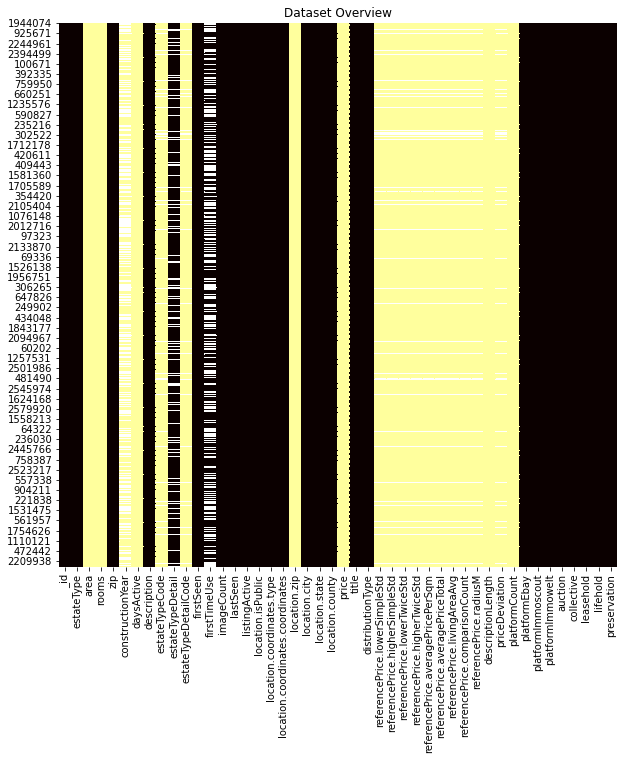

In [ ]:
dic_cols = {col:utils_recognize_type(df, col) for col in df.columns}
heatmap = df.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.9 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
plt.subplots(figsize=(10,10))
sns.heatmap(heatmap, cbar=False, cmap="hot").set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categorical ", "\033[1;30;43m Numeric ", "\033[1;30;47m NaN ")

In [ ]:
df = df.set_index("_id")

 Categorical   Numeric   NaN 


In [ ]:
def visualizeDistribution(df, column):
  x = column
  fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
  fig.suptitle(x, fontsize=20)

  ### distribution
  ax[0].title.set_text('distribution')
  variable = df[x].fillna(df[x].mean())
  breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
  variable = variable[ (variable > breaks[0]) & (variable < 
                      breaks[10]) ]
  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
  des = df[x].describe()
  ax[0].axvline(des["25%"], ls='--')
  ax[0].axvline(des["mean"], ls='--')
  ax[0].axvline(des["75%"], ls='--')
  ax[0].grid(True)
  des = round(des, 2).apply(lambda x: str(x))
  box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
  ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

  ### boxplot 
  ax[1].title.set_text('outliers (log scale)')
  tmp_df = pd.DataFrame(df[x])
  tmp_df[x] = np.log(tmp_df[x])
  tmp_df.boxplot(column=x, ax=ax[1])
  plt.show()

In [ ]:
df_rent = df[df["distributionType"] == "rent"]
df_buy = df[df["distributionType"] == "buy"]

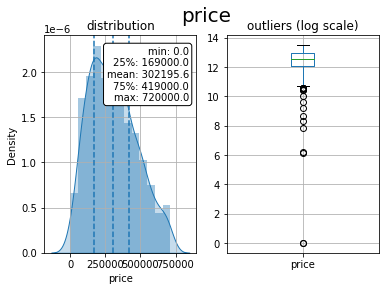

In [ ]:
visualizeDistribution(df_buy, "price")   

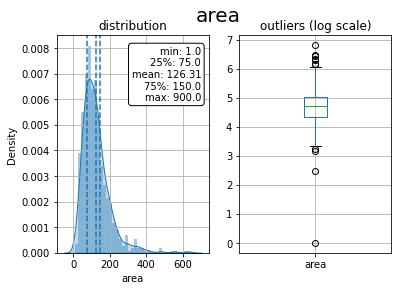

In [ ]:
visualizeDistribution(df_buy, "area")   

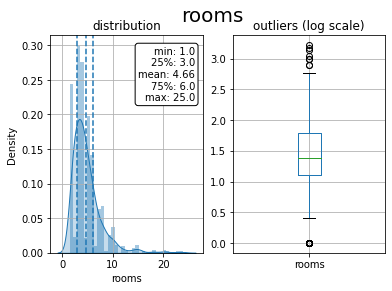

In [ ]:
visualizeDistribution(df_buy, "rooms")   

In [ ]:
def visualizeOrdinal(df, columnName):
  x = columnName
  ax = df[x].value_counts().sort_values().plot(kind="barh")
  totals= []
  for i in ax.patches:
      totals.append(i.get_width())
  total = sum(totals)
  for i in ax.patches:
      ax.text(i.get_width()+.3, i.get_y()+.20, 
      str(round((i.get_width()/total)*100, 2))+'%', 
      fontsize=10, color='black')
  ax.grid(axis="x")
  plt.suptitle(x, fontsize=20)
  plt.show()

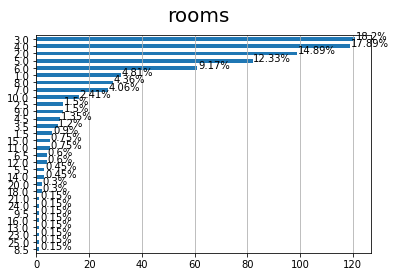

In [ ]:
visualizeOrdinal(df_buy, "rooms")

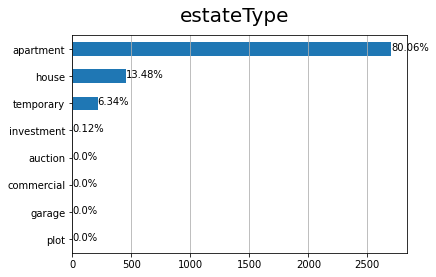

In [ ]:
visualizeOrdinal(df, "estateType")

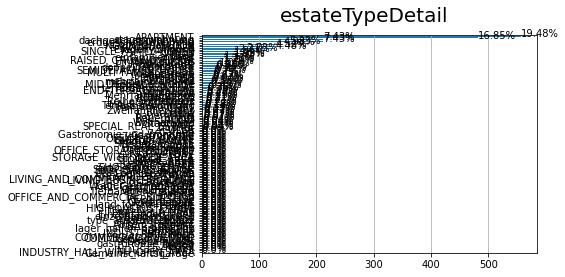

In [ ]:
visualizeOrdinal(df, "estateTypeDetail")

In [ ]:
def visualizeCategoryPriceImpact(dtf, columnName):
  cat, num = columnName, "price"
  fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False)
  fig.suptitle(cat+"   vs   "+num, fontsize=20)
              
  ### distribution
  ax[0].title.set_text('density')
  for i in dtf[cat].unique():
      sns.distplot(dtf[dtf[cat]==i][num], hist=False, label=i, ax=ax[0])
  ax[0].grid(True)
  
  ### stacked
  ax[1].title.set_text('bins')
  breaks = np.quantile(dtf[num], q=np.linspace(0,1,11))
  tmp = dtf.groupby([cat, pd.cut(dtf[num], breaks, duplicates='drop')]).size().unstack().T
  tmp = tmp[dtf[cat].unique()]
  tmp["tot"] = tmp.sum(axis=1)
  for col in tmp.drop("tot", axis=1).columns:
      tmp[col] = tmp[col] / tmp["tot"]
  tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
  
  ### boxplot   
  ax[2].title.set_text('outliers')
  sns.catplot(x=cat, y=num, data=dtf, kind="box", ax=ax[2])
  ax[2].grid(True)
  plt.show()

                                     estateType   area  ...  lifehold preservation
_id                                                     ...                       
3297030a-d6e9-48c6-8af2-a3db5832ca97      house  410.0  ...     False        False

[1 rows x 45 columns]


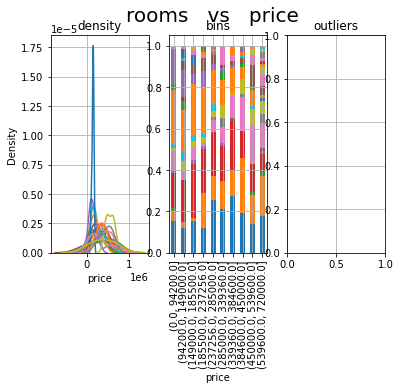

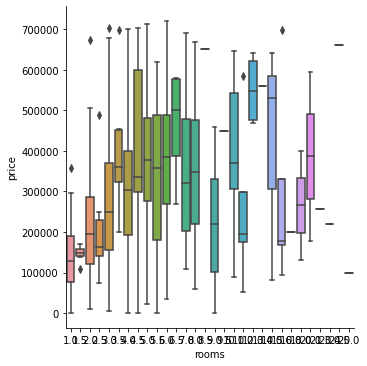

In [ ]:
print(df_buy[df_buy['rooms'] == max(df_buy['rooms'])].head())
visualizeCategoryPriceImpact(df_buy, "rooms")

In [ ]:
def anovaTest(dtf, columnName):
  cat, num = columnName, "price"
  model = smf.ols(num+' ~ '+cat, data=dtf).fit()
  table = sm.stats.anova_lm(model)
  p = table["PR(>F)"][0]
  coeff, p = None, round(p, 3)
  conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
  print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

In [ ]:
anovaTest(df_buy, "area")

Anova F: the variables are Correlated (p-value: 0.0)


In [ ]:
def col_vs_price(dtf, columnName):
  x, y = columnName, "price"
  figsize = (5,5)

  ### bin plot
  dtf_noNan = dtf[dtf[x].notnull()]
  breaks = np.quantile(dtf_noNan[x], q=np.linspace(0, 1, 11))
  groups = dtf_noNan.groupby([pd.cut(dtf_noNan[x], bins=breaks, 
            duplicates='drop')])[y].agg(['mean','median','size'])
  fig, ax = plt.subplots(figsize=figsize)
  fig.suptitle(x+"   vs   "+y, fontsize=20)
  groups[["mean", "median"]].plot(kind="line", ax=ax)
  groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                      color="grey", alpha=0.3, grid=True)
  ax.set(ylabel=y)
  ax.right_ax.set_ylabel("Observazions in each bin")
  plt.show()
  
  ### scatter plot
  sns.jointplot(x=x, y=y, data=dtf, dropna=True, kind='reg', 
                height=int((figsize[0]+figsize[1])/2) )
  plt.show()

  ### pearson correlation
  dtf_noNan = dtf[dtf[x].notnull()]
  coeff, p = ss.stats.pearsonr(dtf_noNan[x], dtf_noNan[y])
  coeff, p = round(coeff, 3), round(p, 3)
  conclusion = "Significant" if p < 0.05 else "Non-Significant"
  print("\nPearson Correlation:", coeff, conclusion, "(p-value: "+str(p)+")")

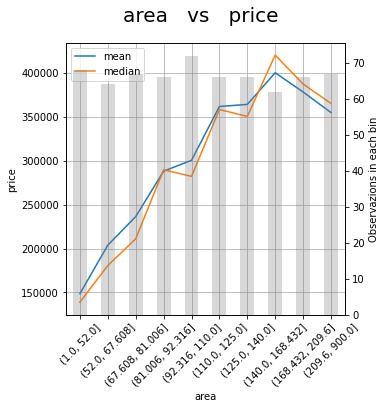

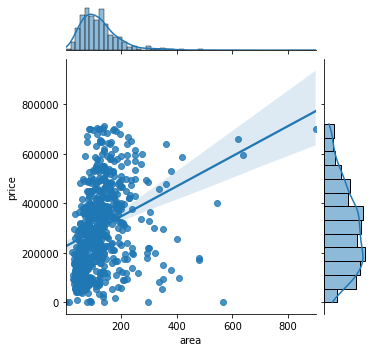


Pearson Correlation: 0.302 Significant (p-value: 0.0)


In [ ]:
col_vs_price(df_buy, "area")

In [ ]:
### Cramer's V for checking symmetry (combined occurence) between two categorical variables

def cramers_v(dft, x, y):
    x, y = dft[x], dft[y]
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [ ]:
cramers_v(df_buy, "estateTypeDetailCode", "estateTypeDetail")

0.9656212275968883

# Text Extraction

In [ ]:
#Mine for these words. More complex approaches (naive extesions) like More synonyms did not improve results. 
categories = [
              #('Groceries', ['Aldi','EDEKA', 'Rewe','Penny', 'Netto', 'Supermarkt','Supermärkte','Einkauf']),
              #('Outdoors', ['Ausflugsziele', 'Erholen','Erholung','Erholungs-', 'Wandern','Wanderung','Wanderwege']),
              ('Balcony', ['Balkon']),
              ('Kitchen', ['Einbaukleinküche','Einbauküche']),
              #('Gas', ['Gas']),
              ('Elevator', ['Aufzug','Aufzügen']),
              #('Freetime', ['Freizeit']),
              #('Garden', ['Garten']),
              ('Parking', ['Auto', 'Parken', 'garage']),
              #('Refurbished', ['modernisiert','saniert']),
              ('Green', ['Grün']), 
              #('Cellar', ['Keller']),
              ('Culture', ['Kultur', 'Kunst']),
              ('School', ['Gymnasium', 'Schule']),
              ('Parcet', ['Parkett'])
              #('Laminat', ['Laminat']),
              #('Sport', ['Sport','verein']),
              #('publicTransport', ['S-Bahn', 'Bahn','tram','U-','Bus', 'ÖPNV']),
              #('Terrace', ['Terasse']),
              #('Uni', ['Universität', 'FH', 'Uni'])
]
dummies = []

for c in categories:
  dummies.append(c[0])


# Description feature extraction
def clean_text(text):
  text = text.replace('<br','')
  text = text.replace('/>','')
  text = text.replace('(','')
  text = text.replace(')','')
  text = text.replace('.','')
  text = text.replace('!','')
  text = text.replace('#','')
  text = text.replace('&','')
  text = text.replace('€','')
  text = text.replace('*','')
  text = text.replace('+','')
  text = text.replace("'",'')
  return text


# This function updates the data_frame with new columns for all keywords 
def mineCategorical(dataFrame, newColName, keywords):
  def oneHot(text):
    for keyword in keywords:
      if keyword.lower() in text:
        return 1
    return 0
  newCol = np.zeros(len(dataFrame))
  for i in range(0,len(dataFrame)):
    newCol[i] = oneHot(clean_text(dataFrame.iloc[i]['description']).lower())
  dataFrame[newColName] = newCol
  return dataFrame


#Use like update of data frame like:
  
for cat in categories:
  df = mineCategorical(df, cat[0], cat[1])

#Necessary to have structure like cat in this loop. I.e. list of tuples where 
#first index of each tuple is the new column name (in df) and 
#index 1 of of each tuple is a list of the search keywords to be considered. 

df.head(1)

,estateType,area,rooms,zip,constructionYear,daysActive,description,estateTypeCode,estateTypeDetail,estateTypeDetailCode,firstSeen,firstTimeUse,imageCount,lastSeen,listingActive,location.isPublic,location.coordinates.type,location.coordinates.coordinates,location.zip,location.city,location.state,location.county,price,title,distributionType,referencePrice.lowerSimpleStd,referencePrice.higherSimpleStd,referencePrice.lowerTwiceStd,referencePrice.higherTwiceStd,referencePrice.averagePricePerSqm,referencePrice.averagePriceTotal,referencePrice.livingAreaAvg,referencePrice.comparisonCount,referencePrice.radiusM,descriptionLength,priceDeviation,platformCount,platformEbay,platformImmoscout,platformImmowelt,auction,collective,leasehold,lifehold,preservation,Balcony,Kitchen,Elevator,Parking,Green,Culture,School,Parcet
_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3b4cb1d5-1a8a-4f88-9cb2-9ba6cc94e6f8,apartment,100.0,4.0,65183,NaN,10.997144,Diese 4 Zimmerwohnung befindet sich im 2. OG (...,0.0,APARTMENT,118.0,2021-03-08T20:17:21.680Z,False,8,2021-03-19T20:13:14.891Z,False,False,Point,"[8.231735329208757,50.08181655222986]",65183.0,Wiesbaden,Hessen,Wiesbaden,750.0,Großzügige 4ZKB Altbau-Wohnung in Wi-Westend,rent,9.0,12.4,7.6,14.6,10.5,1053.9,69.0,500.0,400.0,1142.0,-0.288358,1.0,False,True,False,False,False,False,False,False,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


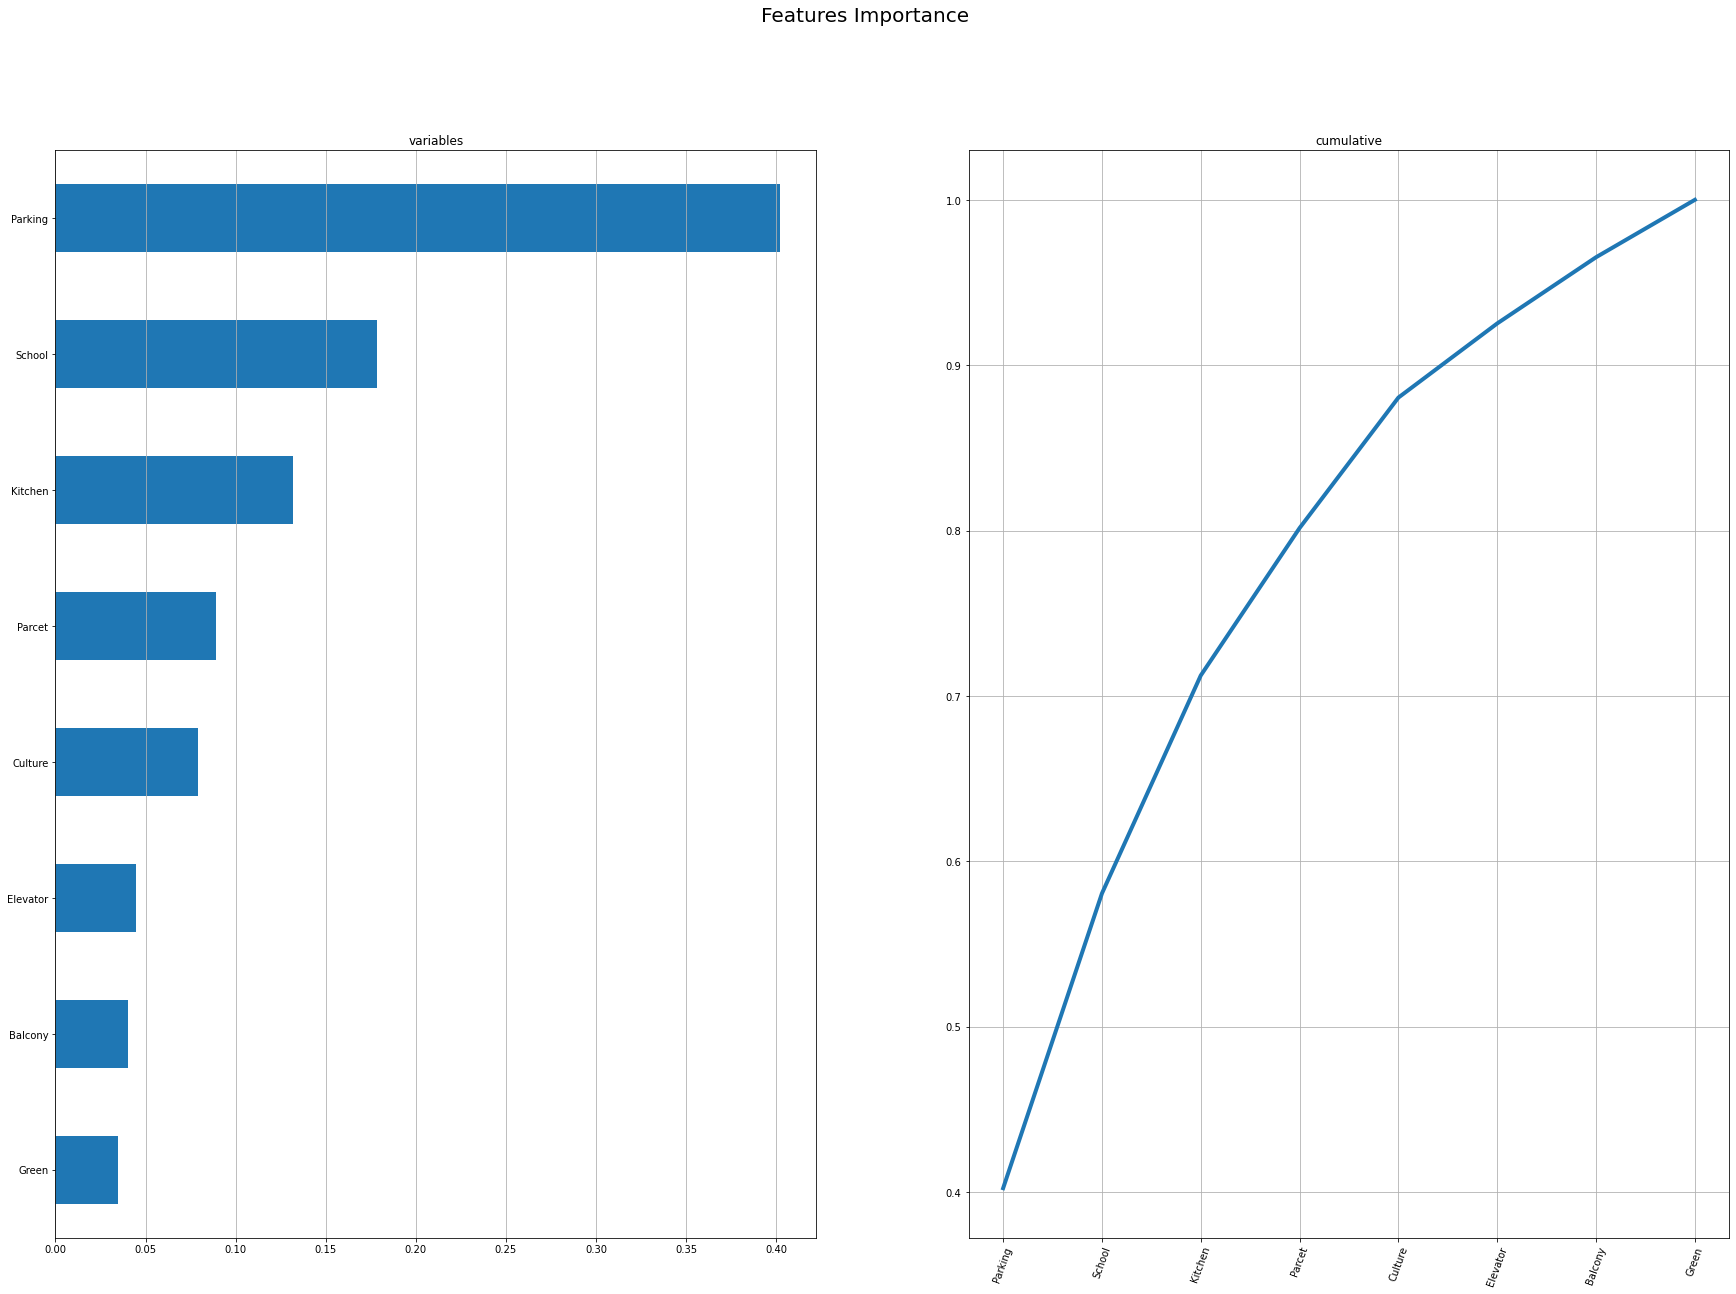

In [ ]:
# Feature Extraction
df = df[['Balcony', 'Kitchen', 'Elevator', 'Parking', 'Green', 'Culture', 'School', 'Parcet', 'price']]

X = df.drop("price", axis=1).values
y = df["price"].values
feature_names = df.drop("price", axis=1).columns.tolist()

## call model
model = ensemble.GradientBoostingRegressor()

## Importance
model.fit(X,y)
importances = model.feature_importances_

## Put in a pandas df
df_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
df_importances['cumsum'] =  df_importances['IMPORTANCE'].cumsum(axis=0)
df_importances = df_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(30,20))
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
df_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
                kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
df_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(df_importances)), 
          xticklabels=df_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

# Regression

## Pre-Processing

### Functions for Pre-processing

In [ ]:
def create_dummies(dtf, categorical_variables):
  ## create dummy
  for v in categorical_variables:
    dummy = pd.get_dummies(dtf[v], prefix=v, drop_first=True)
    dtf= pd.concat([dtf, dummy], axis=1)
    ## drop the original categorical column
    dtf = dtf.drop(v, axis=1)

  for col in dtf:
    if col in binary_variables:
      dtf[col] = dtf[col].replace(True, 1) 
      dtf[col] = dtf[col].replace(False, 0)  
      dtf[col] = dtf[col].replace('false', 0)  
      dtf[col] = dtf[col].replace('true', 1)  
      dtf[col] = pd.to_numeric(dtf[col]) * 1

  return dtf

In [ ]:
def scaling(dtf, y, scalerX=None, scalerY=None, fitted=False, task="classification"):
    scalerX = preprocessing.MinMaxScaler(feature_range=(0,1)) if scalerX is None else scalerX
    if fitted is False:
        scalerX.fit(dtf.drop(y, axis=1))
    X = scalerX.transform(dtf.drop(y, axis=1))
    dtf_scaled = pd.DataFrame(X, columns=dtf.drop(y, axis=1).columns, index=dtf.index)
    if task == "regression":
        scalerY = preprocessing.MinMaxScaler(feature_range=(0,1)) if scalerY is None else scalerY
        dtf_scaled[y] = scalerY.fit_transform(dtf[y].values.reshape(-1,1)) if fitted is False else dtf[y]
        return dtf_scaled, scalerX, scalerY
    else:
        dtf_scaled[y] = dtf[y]
        return dtf_scaled, scalerX

In [ ]:
def transform_boolean_to_binary(df, binary_variables):
  for col in df:
    if col in binary_variables:
      df[col] = df[col].replace(True, 1) 
      df[col] = df[col].replace(False, 0)  
      df[col] = df[col].replace('false', 0)  
      df[col] = df[col].replace('true', 1)  
      df[col] = pd.to_numeric(df[col]) * 1

  return df

In [ ]:
def fill_na(dtf, x, value=None):
    if value is None:
        value = dtf[x].mean() if utils_recognize_type(dtf, x) == "num" else dtf[x].mode().iloc[0]
        print("--- Replacing Nas with:", value, "---")
        dtf[x] = dtf[x].fillna(value)
        return dtf, value
    else:
        print("--- Replacing Nas with:", value, "---")
        dtf[x] = dtf[x].fillna(value)
        return dtf

In [ ]:
# Scaling - Fit robust scaler
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))

### Data Preparation

In [ ]:
## Select only listings to buy

df_buy = df[df["distributionType"]=="buy"]
df_buy = df_buy[df_buy['estateTypeDetailCode'] != 0]
df_buy = df_buy[df_buy['estateType'] != 'investment']
df_buy = df_buy[df_buy['descriptionLength'].notna()]
df_buy = df_buy.set_index("_id")

In [ ]:
df_buy['estateTypeDetail'] = df_buy['estateTypeDetail'].str.lower()

In [ ]:
di= {
    'doppelhaushälfte':'semidetached_house',
    'doppelhaushaelfte':'semidetached_house',
    'semidetached_house':'semidetached_house',
    'roof_storey': 'roof_storey',
    'dachgeschosswohnung': 'roof_storey',
    'einfamilienhaus':'single_family_house',
    'single_family_house':'single_family_house',
    'etagenwohnung': 'maisonette',
    'maisonette': 'maisonette',
    'apartment': 'apartment',
    'mehrfamilienhaus': 'multi_family_house',
    'multi_family_house': 'multi_family_house',
    'erdgeschosswohnung': 'ground_floor',
    'ground_floor': 'ground_floor',
    'reihenhaus': 'terrace_house',
    'mid_terrace_house':'mid_terrace_house',
    'reihenmittelhaus':'mid_terrace_house',
    'end_terrace_house':'end_terrace_house',
    'reihenendhaus':'end_terrace_house',
    'terraced_flat':'terraced_flat',
    'terrassenwohnung':'terraced_flat',
    'villa':'villa',
    'bungalow':'bungalow',
    'hochparterre':'raised_ground_floor',
    'raised_ground_floor':'raised_ground_floor',
    'wohnanlage':'wohnanlage',
    'apartmenthaus':'apartment_building',
    'geschäftshaus':'commercial_building',
    'penthouse':'penthouse',
    'half_basement':'half_basement',
    'souterrain':'half_basement',
    'herrenhaus':'mansion',
    'wohn-geschäftshaus':'living_and_commercial_building',
    'zweifamilienhaus':'two_family_house',
    'loft':'loft',
    'seniorenheim':'pension_home',
    'no_information': 'no_information',
    'nan':'other',
    'other':'other',
    'andere':'other',
}

In [ ]:
# Add newly coded Type to dataframe
df_buy['type'] = df_buy['estateTypeDetail']
df_buy['type'] = df_buy['type'].apply(lambda x: di.get(x))
df_buy.head(1)

,estateType,area,rooms,zip,constructionYear,daysActive,description,estateTypeCode,estateTypeDetail,estateTypeDetailCode,firstSeen,firstTimeUse,imageCount,lastSeen,listingActive,location.isPublic,location.coordinates.type,location.coordinates.coordinates,location.zip,location.city,location.state,location.county,price,title,distributionType,referencePrice.lowerSimpleStd,referencePrice.higherSimpleStd,referencePrice.lowerTwiceStd,referencePrice.higherTwiceStd,referencePrice.averagePricePerSqm,referencePrice.averagePriceTotal,referencePrice.livingAreaAvg,referencePrice.comparisonCount,referencePrice.radiusM,descriptionLength,priceDeviation,platformCount,platformEbay,platformImmoscout,platformImmowelt,auction,collective,leasehold,lifehold,preservation,Balcony,Kitchen,Elevator,Parking,Green,Culture,School,Parcet,type
_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8186ea13-d12d-4cef-9e19-5d448f83c738,house,193.01,4.0,48527,1961.0,13.99206,Sie erreichen uns von Montag - Freitag von 08:...,3.0,other,126.0,2021-01-04T21:47:38.130Z,False,1,2021-01-18T21:36:12.073Z,False,True,Point,"[7.041482086177442,52.42713925182555]",48527.0,Nordhorn,Niedersachsen,Grafschaft Bentheim (Kreis),131300.0,WOHNHAUS MIT 193.01m² WOHNFLÄCHE,buy,169000.0,425000.0,106000.0,675000.0,1400.0,268000.0,154.0,202.0,10000.0,1901.0,-0.510075,1.0,False,True,False,True,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,other


In [ ]:
## set variables for model design

columnsToDrop = ['firstSeen', 'lastSeen', 'description', 'location.coordinates.coordinates', 
                'location.coordinates.type', 'title', 'location.county', 'location.zip', 'descriptionLength',
                'referencePrice.lowerSimpleStd',	'referencePrice.higherSimpleStd',	'imageCount',
                'referencePrice.lowerTwiceStd',	'referencePrice.higherTwiceStd',	'listingActive', 'daysActive',
                'referencePrice.averagePricePerSqm',	'referencePrice.averagePriceTotal',	'zip',
                'referencePrice.livingAreaAvg',	'referencePrice.comparisonCount',	'platformEbay', 'platformImmoscout', 'platformImmowelt',
                'referencePrice.radiusM', 'priceDeviation', 'estateType', 'firstTimeUse', 'platformCount',
                'estateTypeDetail', 'distributionType', 'estateTypeDetailCode', 'estateTypeCode', 'location.city']

binary_variables = ['location.isPublic', 'listingActive', 'platformEbay', 'platformImmoscout', 'platformImmowelt', 
                    'auction', 'collective', 'leasehold', 'lifehold', 'preservation']

categorical_variables = ['estateType',  'description', 'estateTypeDetail', 'lastSeen', 'listingActive', 
                        'location.coordinates.type', 'location.coordinates.coordinates', 'location.city',
                        'location.state', 'location.county',  'title', 'type', 'zip']

categorical_variables_to_transform = ['type', 'location.state']

In [ ]:
df_buy = create_dummies(df_buy, categorical_variables_to_transform)

### Partitioning

In [ ]:
## split data
df_train, df_test = model_selection.train_test_split(df_buy, test_size=0.3)

## print info
print("X_train shape:", df_train.drop("price",axis=1).shape, "| X_test shape:", df_test.drop("price",axis=1).shape)
print("y_train mean:", round(np.mean(df_train["price"]),2), "| y_test mean:", round(np.mean(df_test["price"]),2))
print(df_train.shape[1], "features:", df_train.drop("price",axis=1).columns.to_list())

X_train shape: (695, 84) | X_test shape: (299, 84)
y_train mean: 338630.43 | y_test mean: 359665.73
85 features: ['estateType', 'area', 'rooms', 'zip', 'constructionYear', 'daysActive', 'description', 'estateTypeCode', 'estateTypeDetail', 'estateTypeDetailCode', 'firstSeen', 'firstTimeUse', 'imageCount', 'lastSeen', 'listingActive', 'location.isPublic', 'location.coordinates.type', 'location.coordinates.coordinates', 'location.zip', 'location.city', 'location.county', 'title', 'distributionType', 'referencePrice.lowerSimpleStd', 'referencePrice.higherSimpleStd', 'referencePrice.lowerTwiceStd', 'referencePrice.higherTwiceStd', 'referencePrice.averagePricePerSqm', 'referencePrice.averagePriceTotal', 'referencePrice.livingAreaAvg', 'referencePrice.comparisonCount', 'referencePrice.radiusM', 'descriptionLength', 'priceDeviation', 'platformCount', 'platformEbay', 'platformImmoscout', 'platformImmowelt', 'auction', 'collective', 'leasehold', 'lifehold', 'preservation', 'Balcony', 'Kitchen', 

### Train set

In [ ]:
df_train = df_train.drop(columns=columnsToDrop)

In [ ]:
df_train, constructionYear_mean = fill_na(df_train, x="constructionYear")

--- Replacing Nas with: 1974.9983277591973 ---


In [ ]:
df_train = transform_boolean_to_binary(df_train, binary_variables)

In [ ]:
df_train, scalerX, scalerY = scaling(df_train, y="price", scalerX=scalerX, scalerY=scalerY, task="regression")

In [ ]:
df_train.head(2)

,area,rooms,constructionYear,location.isPublic,auction,collective,leasehold,lifehold,preservation,Balcony,Kitchen,Elevator,Parking,Green,Culture,School,Parcet,type_bungalow,type_end_terrace_house,type_ground_floor,type_half_basement,type_maisonette,type_mid_terrace_house,type_multi_family_house,type_no_information,type_other,type_penthouse,type_raised_ground_floor,type_roof_storey,type_semidetached_house,type_single_family_house,type_terrace_house,type_terraced_flat,type_villa,location.state_Bayern,location.state_Berlin,location.state_Brandenburg,location.state_Bremen,location.state_Hamburg,location.state_Hessen,location.state_Mecklenburg-Vorpommern,location.state_Niedersachsen,location.state_Nordrhein-Westfalen,location.state_Rheinland-Pfalz,location.state_Saarland,location.state_Sachsen,location.state_Sachsen-Anhalt,location.state_Schleswig-Holstein,location.state_Thüringen,location.state_Unbekannt,price
_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
641b7912-d8ec-40ea-b399-4e5a199d684d,0.341588,0.5,-0.363593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.744224
a28f53e3-9dd4-4569-bbc7-8c704b65c0fe,0.745284,0.0,0.519524,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.670172


### Test set

In [ ]:
df_test = df_test.drop(columns=columnsToDrop)

In [ ]:
df_test, _ = fill_na(df_test, x="constructionYear")

--- Replacing Nas with: 1975.7300380228137 ---


In [ ]:
df_test.head(1)

,area,rooms,constructionYear,location.isPublic,price,auction,collective,leasehold,lifehold,preservation,Balcony,Kitchen,Elevator,Parking,Green,Culture,School,Parcet,type_bungalow,type_end_terrace_house,type_ground_floor,type_half_basement,type_maisonette,type_mid_terrace_house,type_multi_family_house,type_no_information,type_other,type_penthouse,type_raised_ground_floor,type_roof_storey,type_semidetached_house,type_single_family_house,type_terrace_house,type_terraced_flat,type_villa,location.state_Bayern,location.state_Berlin,location.state_Brandenburg,location.state_Bremen,location.state_Hamburg,location.state_Hessen,location.state_Mecklenburg-Vorpommern,location.state_Niedersachsen,location.state_Nordrhein-Westfalen,location.state_Rheinland-Pfalz,location.state_Saarland,location.state_Sachsen,location.state_Sachsen-Anhalt,location.state_Schleswig-Holstein,location.state_Thüringen,location.state_Unbekannt
_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98766347-94cf-4580-bc06-80208106b826,43.0,1.0,1989.0,1,160000.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_test = transform_boolean_to_binary(df_test, binary_variables)

In [ ]:
df_test, _, _ = scaling(df_test, y="price", scalerX=scalerX, scalerY=scalerY, fitted=True, task="regression")

In [ ]:
df_test.head(2)

,area,rooms,constructionYear,location.isPublic,auction,collective,leasehold,lifehold,preservation,Balcony,Kitchen,Elevator,Parking,Green,Culture,School,Parcet,type_bungalow,type_end_terrace_house,type_ground_floor,type_half_basement,type_maisonette,type_mid_terrace_house,type_multi_family_house,type_no_information,type_other,type_penthouse,type_raised_ground_floor,type_roof_storey,type_semidetached_house,type_single_family_house,type_terrace_house,type_terraced_flat,type_villa,location.state_Bayern,location.state_Berlin,location.state_Brandenburg,location.state_Bremen,location.state_Hamburg,location.state_Hessen,location.state_Mecklenburg-Vorpommern,location.state_Niedersachsen,location.state_Nordrhein-Westfalen,location.state_Rheinland-Pfalz,location.state_Saarland,location.state_Sachsen,location.state_Sachsen-Anhalt,location.state_Schleswig-Holstein,location.state_Thüringen,location.state_Unbekannt,price
_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98766347-94cf-4580-bc06-80208106b826,-1.071345,-1.50,0.363680,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160000.0
33ebc7f0-9d8e-4182-8047-550b94b8b493,0.481329,0.75,0.019005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,420000.0


## Feature Extraction

Text(0.5, 1.0, 'pearson correlation')

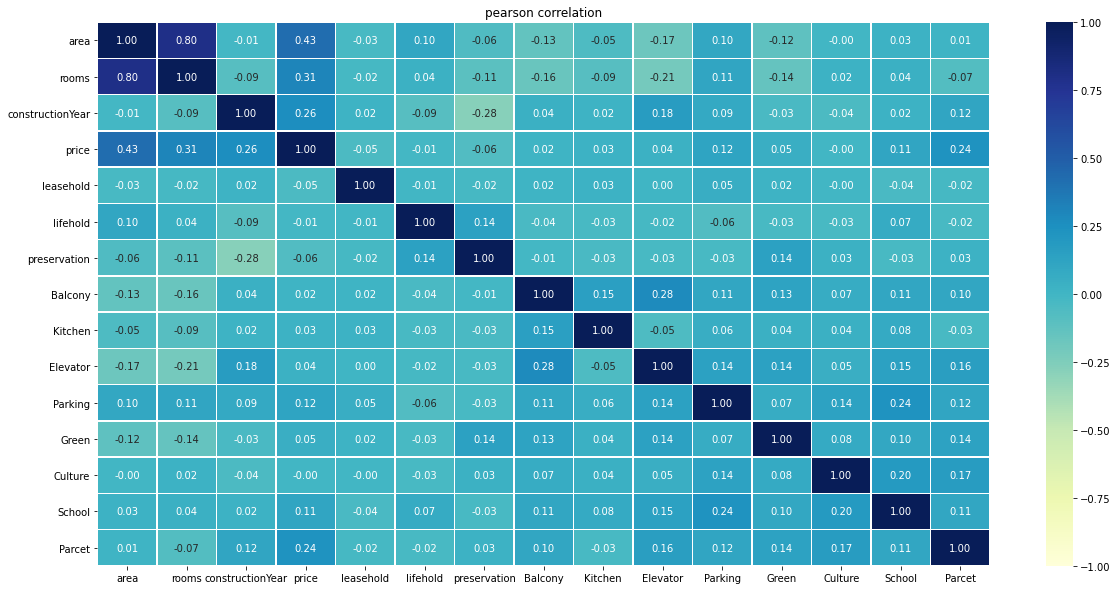

In [ ]:
## identify multicollinearity
corr_matrix = df_train.drop(columns='collective').corr(method="pearson")
plt.subplots(figsize=(20,10))
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

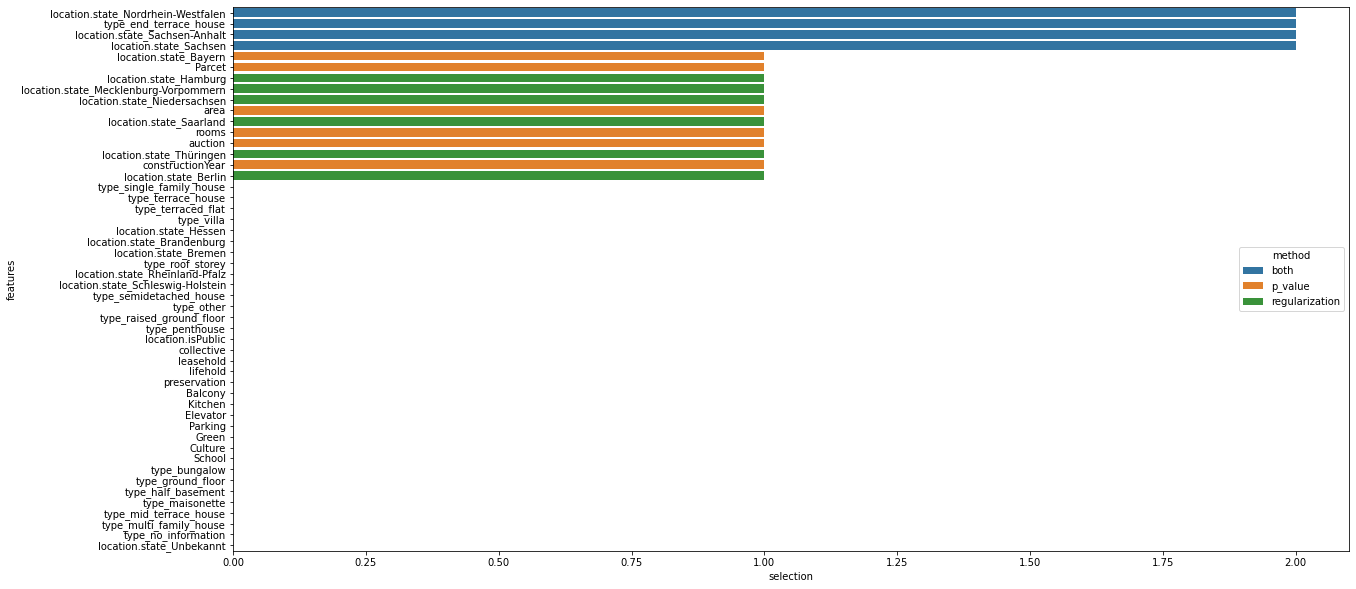

In [ ]:
## RIDGE regularization

X = df_train.drop("price", axis=1).values
y = df_train["price"].values
feature_names = df_train.drop("price", axis=1).columns

## p-value
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_regression, k=10).fit(X,y)
pvalue_selected_features = feature_names[selector.get_support()]

## regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.Ridge(alpha=1.0, fit_intercept=True), 
                                 max_features=10).fit(X,y)
regularization_selected_features = feature_names[selector.get_support()]
 
## plot
df_features = pd.DataFrame({"features":feature_names})
df_features["p_value"] = df_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
df_features["num1"] = df_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)
df_features["regularization"] = df_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
df_features["num2"] = df_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)
df_features["method"] = df_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
df_features["selection"] = df_features["num1"] + df_features["num2"]
df_features["method"] = df_features["method"].apply(lambda x: "both" if len(x.split()) == 2 else x)
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(y="features", x="selection", hue="method", data=df_features.sort_values("selection", ascending=False), dodge=False)

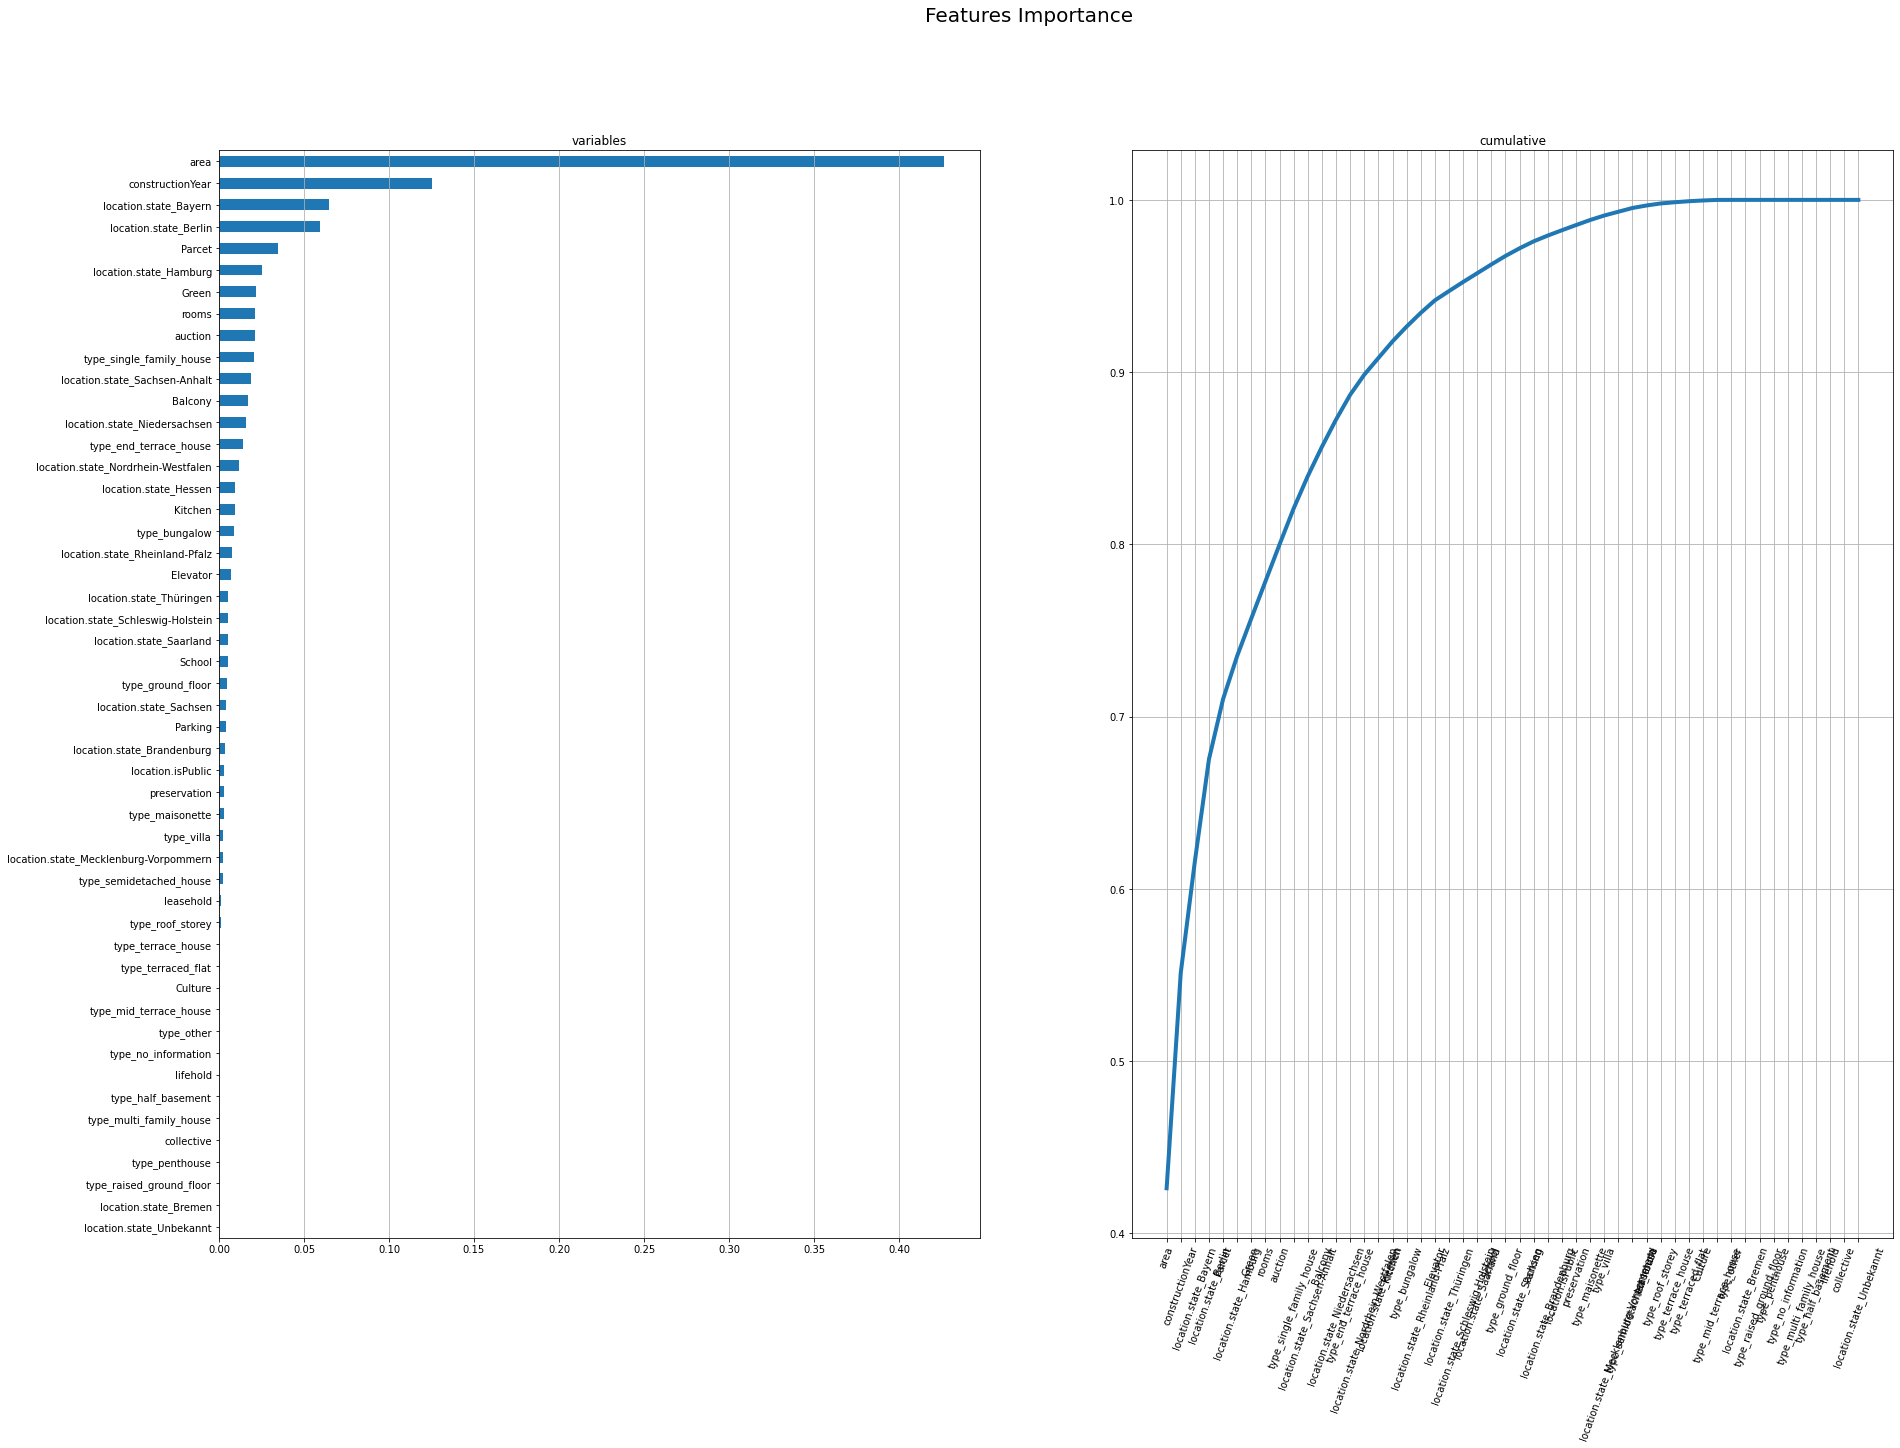

In [ ]:
# Feature Extraction

X = df_train.drop("price", axis=1).values
y = df_train["price"].values
feature_names = df_train.drop("price", axis=1).columns.tolist()

## call model
model = ensemble.GradientBoostingRegressor()

## Importance
model.fit(X,y)
importances = model.feature_importances_

## Put in a pandas df
df_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
df_importances['cumsum'] =  df_importances['IMPORTANCE'].cumsum(axis=0)
df_importances = df_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(30,20))
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
df_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
                kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
df_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(df_importances)), 
          xticklabels=df_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

## Model Design

In [ ]:
X_names = list(df_train.columns)
X_names.remove('price')

X_train = df_train[X_names].values
y_train = df_train["price"].values
X_test = df_test[X_names].values
y_test = df_test["price"].values

### Random Search Model

In [ ]:
model_complex = ensemble.GradientBoostingRegressor()
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],      #weighting factor for the corrections by new trees when added to the model
             'n_estimators':[100,250,500,750,1000,1250,1500,1750],  #number of trees added to the model
             'max_depth':[2,3,4,5,6,7],                             #maximum depth of the tree
             'min_samples_split':[2,4,6,8,10,20,40,60,100],         #sets the minimum number of samples to split
             'min_samples_leaf':[1,3,5,7,9],                        #the minimum number of samples to form a leaf
             'max_features':[2,3,4,5,6,7],                          #square root of features is usually a good starting point
             'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}            #the fraction of samples to be used for fitting the individual base learners. Values lower than 1 generally lead to a reduction of variance and an increase in bias.

In [ ]:
def tune_regr_model(X_train, y_train, model_base=None, param_dic=None, scoring="r2", searchtype="RandomSearch", n_iter=1000, cv=10, figsize=(10,5)):
    model_base = ensemble.GradientBoostingRegressor() if model_base is None else model_base
    param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750], 'max_depth':[2,3,4,5,6,7]} if param_dic is None else param_dic                        

    ## Search
    print("---", searchtype, "---")
    if searchtype == "RandomSearch":
        random_search = model_selection.RandomizedSearchCV(model_base, param_distributions=param_dic, n_iter=n_iter, scoring=scoring).fit(X_train, y_train)
        print("Best Model parameters:", random_search.best_params_)
        print("Best Model "+scoring+":", round(random_search.best_score_, 2))
        model = random_search.best_estimator_
    
    elif searchtype == "GridSearch":
        grid_search = model_selection.GridSearchCV(model_base, param_dic, scoring=scoring).fit(X_train, y_train)
        print("Best Model parameters:", grid_search.best_params_)
        print("Best Model mean "+scoring+":", round(grid_search.best_score_, 2))
        model = grid_search.best_estimator_
    
    ## K fold validation
    print("")
    print("--- Kfold Validation ---")
    Kfold_base = model_selection.cross_validate(estimator=model_base, X=X_train, y=y_train, cv=cv, scoring=scoring)
    Kfold_model = model_selection.cross_validate(estimator=model, X=X_train, y=y_train, cv=cv, scoring=scoring)
    print(scoring, "mean - base model:", round(Kfold_base["test_score"].mean(),2), " --> best model:", round(Kfold_model["test_score"].mean()))
    
    scores = []
    cv = model_selection.KFold(n_splits=cv, shuffle=True)
    fig = plt.figure(figsize=figsize)
    i = 1
    for train, test in cv.split(X_train, y_train):
        prediction = model.fit(X_train[train], y_train[train]).predict(X_train[test])
        true = y_train[test]
        score = metrics.r2_score(true, prediction)
        scores.append(score)
        plt.scatter(prediction, true, lw=2, alpha=0.3, label='Fold %d (R2 = %0.2f)' % (i,score))
        i = i+1
    plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], linestyle='--', lw=2, color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('K-Fold Validation')
    plt.legend()
    plt.show()
    
    return model

In [ ]:
def fit_ml_regr(model, X_train, y_train, X_test, scalerY=None):  
    ## model
    model = ensemble.GradientBoostingRegressor() if model is None else model
    
    ## train/test
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    if scalerY is not None:
        predicted = scalerY.inverse_transform(predicted.reshape(-1,1)).reshape(-1)
    return model, predicted

--- RandomSearch ---
Best Model parameters: {'subsample': 1, 'n_estimators': 250, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 4, 'max_depth': 4, 'learning_rate': 0.1}
Best Model r2: 0.44

--- Kfold Validation ---
r2 mean - base model: 0.43  --> best model: 0


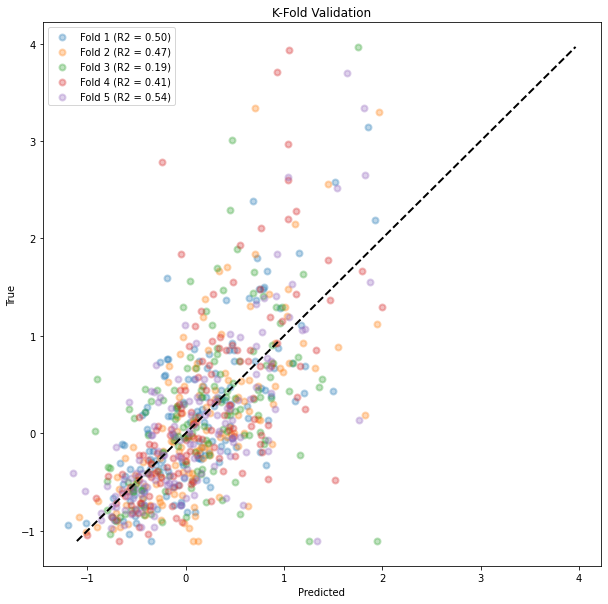

In [ ]:
model_RS = tune_regr_model(X_train, y_train, model_complex, param_dic, scoring="r2", 
                        searchtype="RandomSearch", n_iter=100, cv=5, figsize=(10,10))

In [ ]:
model_RS, predicted = fit_ml_regr(model_RS, X_train, y_train, X_test, scalerY)

### Linear Regression Model

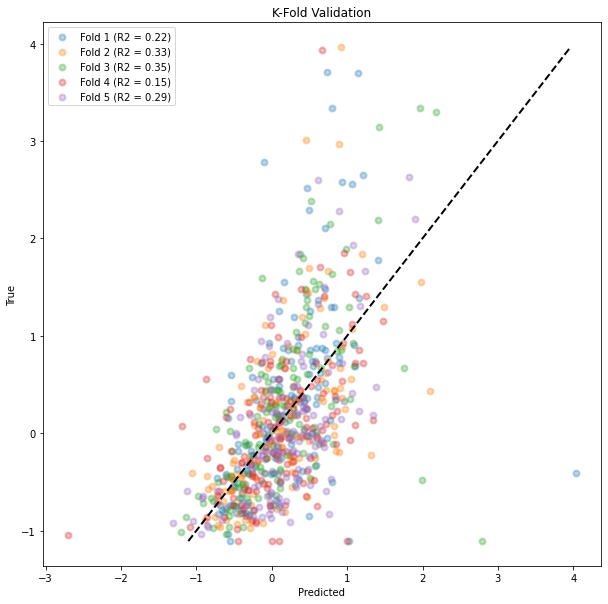

In [ ]:
## call model
model_LR = linear_model.LinearRegression()

## K fold validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig, ax = plt.subplots(figsize=(10,10))
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model_LR.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
    
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

## Prediction

In [ ]:
#Prediction

def predictPrice(model, X_train, y_train, X_test):
  ## train
  model.fit(X_train, y_train)
  ## test
  predicted = model.predict(X_test)
  predicted = scalerY.inverse_transform(predicted.reshape(-1,1) ).reshape(-1)

  return predicted

In [ ]:
predicted = predictPrice(model_RS, X_train, y_train, X_test)

## Model Evaluation

In [ ]:
def evaluate_regr_model(y_test, predicted, figsize=(25,5)):
    ## Kpi
    print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
    print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
    print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
    print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))
    
    ## residuals
    residuals = y_test - predicted
    max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
    max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
    max_true, max_pred = y_test[max_idx], predicted[max_idx]
    print("Max Error:", "{:,.0f}".format(max_error))
    
    ## Plot predicted vs true
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    from statsmodels.graphics.api import abline_plot
    ax[0].scatter(predicted, y_test, color="black")
    abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
    ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
    ax[0].grid(True)
    ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
    ax[0].legend()
    
    ## Plot predicted vs residuals
    ax[1].scatter(predicted, residuals, color="red")
    ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
    ax[1].grid(True)
    ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
    ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
    ax[1].legend()
    
    ## Plot residuals distribution
    sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax[2], label="mean = "+"{:,.0f}".format(np.mean(residuals)))
    ax[2].grid(True)
    ax[2].set(yticks=[], yticklabels=[], title="Residuals distribution")
    plt.show()

R2 (explained variance): 0.5
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.38
Mean Absolute Error (Σ|y-pred|/n): 122,665
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 172,765
Max Error: 784,091


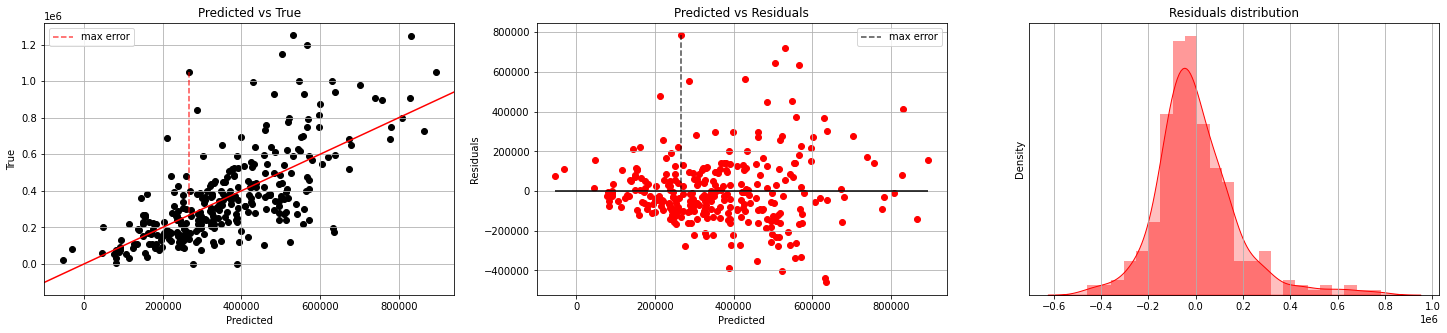

In [ ]:
evaluate_regr_model(y_test, predicted, figsize=(25,5))

In [ ]:
print("True:", "{:,.0f}".format(y_test[1]), "--> Pred:", "{:,.0f}".format(predicted[1]))

True: 420,000 --> Pred: 424,966


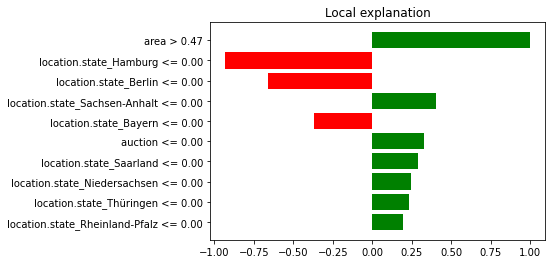

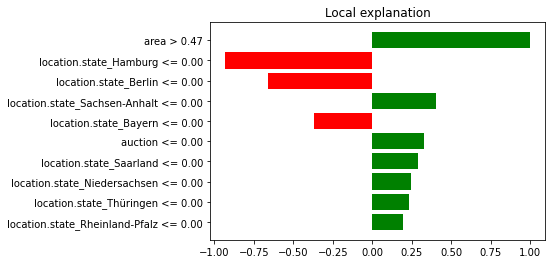

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=X_names, class_names="Y", mode="regression")
explained = explainer.explain_instance(X_test[1], model.predict, num_features=10)
explained.as_pyplot_figure()

# Catboost

In [ ]:
!pip install catboost
from catboost import Pool, CatBoostRegressor

## Data Preparation

In [ ]:
## Select only listings to buy

df_buy = df[df["distributionType"]=="buy"]
df_buy = df_buy[df_buy['estateTypeDetailCode'] != 0]
df_buy = df_buy[df_buy['estateType'] != 'investment']
df_buy = df_buy[df_buy['descriptionLength'].notna()]

# Add newly coded Type to dataframe
df_buy['type'] = df_buy['estateTypeDetail']
df_buy['type'] = df_buy['type'].apply(lambda x: di.get(x))
df_buy['zip'] = df_buy['zip'].astype(str)
df_buy['type'] = df_buy['type'].astype(str)

In [ ]:
df_buy = df_buy.set_index("_id")

In [ ]:
## set variables for model design

columnsToDrop = ['firstSeen', 'lastSeen', 'description', 'location.coordinates.coordinates', 
                'location.coordinates.type', 'title', 'location.county', 'location.zip', 'location.state',
                'descriptionLength','referencePrice.lowerSimpleStd',	'referencePrice.higherSimpleStd',	'imageCount',
                'referencePrice.lowerTwiceStd',	'referencePrice.higherTwiceStd',	'listingActive', 'daysActive',
                'referencePrice.averagePricePerSqm',	'referencePrice.averagePriceTotal',
                'referencePrice.livingAreaAvg',	'referencePrice.comparisonCount',	'platformEbay', 
                 'platformImmoscout', 'platformImmowelt', 'location.isPublic', 'auction',
                'referencePrice.radiusM', 'priceDeviation', 'estateType', 'firstTimeUse', 'platformCount',
                'estateTypeDetail', 'distributionType', 'estateTypeDetailCode', 'estateTypeCode', 'location.city']

binary_variables = ['location.isPublic', 'listingActive', 'platformEbay', 'platformImmoscout', 'platformImmowelt', 
                    'auction', 'collective', 'leasehold', 'lifehold', 'preservation']

categorical_variables = ['estateType',  'description', 'estateTypeDetail', 'lastSeen', 'listingActive', 
                        'location.coordinates.type', 'location.coordinates.coordinates', 'location.city',
                        'location.state', 'location.county',  'title', 'type', 'zip']

In [ ]:
## split data
df_train, df_test = model_selection.train_test_split(df_buy, test_size=0.3)

## print info
print("X_train shape:", df_train.drop("price",axis=1).shape, "| X_test shape:", df_test.drop("price",axis=1).shape)
print("y_train mean:", round(np.mean(df_train["price"]),2), "| y_test mean:", round(np.mean(df_test["price"]),2))
print(df_train.shape[1], "features:", df_train.drop("price",axis=1).columns.to_list())

X_train shape: (695, 53) | X_test shape: (299, 53)
y_train mean: 343745.61 | y_test mean: 347775.93
54 features: ['estateType', 'area', 'rooms', 'zip', 'constructionYear', 'daysActive', 'description', 'estateTypeCode', 'estateTypeDetail', 'estateTypeDetailCode', 'firstSeen', 'firstTimeUse', 'imageCount', 'lastSeen', 'listingActive', 'location.isPublic', 'location.coordinates.type', 'location.coordinates.coordinates', 'location.zip', 'location.city', 'location.state', 'location.county', 'title', 'distributionType', 'referencePrice.lowerSimpleStd', 'referencePrice.higherSimpleStd', 'referencePrice.lowerTwiceStd', 'referencePrice.higherTwiceStd', 'referencePrice.averagePricePerSqm', 'referencePrice.averagePriceTotal', 'referencePrice.livingAreaAvg', 'referencePrice.comparisonCount', 'referencePrice.radiusM', 'descriptionLength', 'priceDeviation', 'platformCount', 'platformEbay', 'platformImmoscout', 'platformImmowelt', 'auction', 'collective', 'leasehold', 'lifehold', 'preservation', 'Bal

In [ ]:
df_train = df_train.drop(columns=columnsToDrop)

In [ ]:
df_train, constructionYear_mean = fill_na(df_train, x="constructionYear")

--- Replacing Nas with: 1976.5226130653266 ---


In [ ]:
df_train = transform_boolean_to_binary(df_train, binary_variables)

In [ ]:
df_test = df_test.drop(columns=columnsToDrop)

In [ ]:
df_test, _ = fill_na(df_test, x="constructionYear")

--- Replacing Nas with: 1972.280303030303 ---


In [ ]:
df_test = transform_boolean_to_binary(df_test, binary_variables)

In [ ]:
df_test.head(1)

,area,rooms,zip,constructionYear,price,collective,leasehold,lifehold,preservation,Balcony,Kitchen,Elevator,Parking,Green,Culture,School,Parcet,type
_id,,,,,,,,,,,,,,,,,,
fb211b9e-c476-46b4-a0d5-eca27fcf7db4,90.0,4.0,66849,1972.280303,136000.0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,maisonette


## Model Design

In [ ]:
# initialize data
train_data = df_train.drop('price', axis=1)
train_label = df_train['price']
test_data = df_test

# initialize Pool
train_pool = Pool(train_data, 
                  train_label, 
                  cat_features=['zip', 'type'])

test_pool = Pool(test_data, 
                 cat_features=['zip', 'type']) 

# specify the training parameters 
params = {'iterations':3000,
        'learning_rate':0.001,
        'depth':10,
        'loss_function':'RMSE',
        'random_seed':55,
        'metric_period':100, # calculate metrics once per 50 iterations
        'od_type':"Iter", # overfit detector
        'od_wait':20, # most recent best iteration to wait before stopping
        'verbose':True}

model_regressor = CatBoostRegressor(**params)

#train the model
model_regressor.fit(train_pool)

# make the prediction using the resulting model
preds = model_regressor.predict(test_pool)

0:	learn: 226306.1255822	total: 1.18ms	remaining: 3.53s
100:	learn: 220875.4360769	total: 923ms	remaining: 26.5s
200:	learn: 215764.2046507	total: 2.02s	remaining: 28.1s
300:	learn: 211103.8502615	total: 3.04s	remaining: 27.3s
400:	learn: 206637.9860572	total: 4.28s	remaining: 27.7s
500:	learn: 202725.3362371	total: 5.38s	remaining: 26.8s
600:	learn: 199069.6904841	total: 6.46s	remaining: 25.8s
700:	learn: 195771.9694421	total: 7.58s	remaining: 24.9s
800:	learn: 192697.7792769	total: 8.78s	remaining: 24.1s
900:	learn: 189799.5510739	total: 9.95s	remaining: 23.2s
1000:	learn: 187178.7894976	total: 11.1s	remaining: 22.1s
1100:	learn: 184514.6548441	total: 12.4s	remaining: 21.4s
1200:	learn: 182083.1030916	total: 13.7s	remaining: 20.5s
1300:	learn: 179709.9514821	total: 14.9s	remaining: 19.5s
1400:	learn: 177511.2172224	total: 16.3s	remaining: 18.5s
1500:	learn: 175483.9395010	total: 17.5s	remaining: 17.5s
1600:	learn: 173606.8426086	total: 18.9s	remaining: 16.5s
1700:	learn: 171768.58112

## Model Evaluation

In [ ]:
model_regressor.score(X=train_data, y=train_label)

0.5081092427453031

In [ ]:
rmse = (np.sqrt(metrics.mean_squared_error(df_test["price"].values, preds)))
r2 = metrics.r2_score(df_test["price"].values, preds)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 207630.56
R2: 0.29


R2 (explained variance): 0.29
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.44
Mean Absolute Error (Σ|y-pred|/n): 146,739
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 207,631
Max Error: 973,604


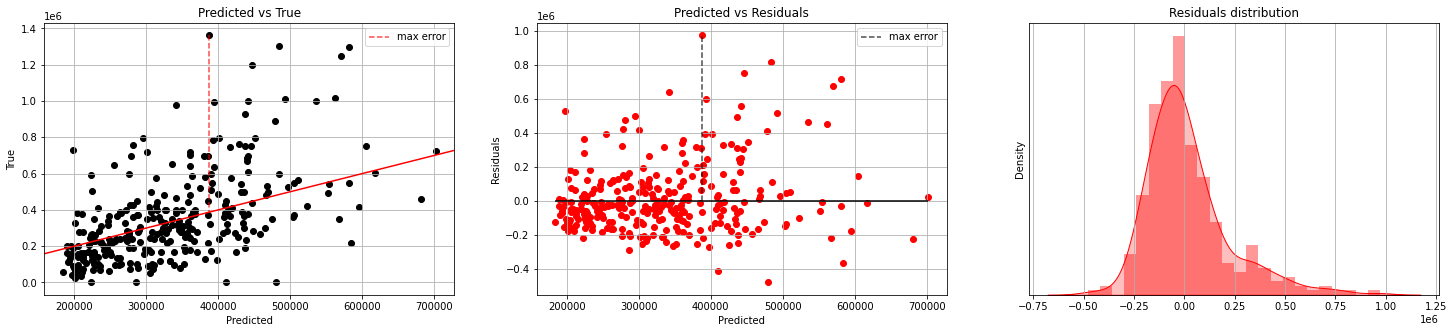

In [ ]:
evaluate_regr_model(df_test["price"].values, preds, figsize=(25,5))

In [ ]:
model_regressor.get_feature_importance(data=None,
                       type='FeatureImportance',
                       prettified=True,
                       thread_count=-1,
                       verbose=False)

,Feature Id,Importances
0,area,33.114877
1,constructionYear,19.104017
2,Parcet,13.103456
3,type,8.949767
4,rooms,5.488828
5,Parking,3.984736
6,Balcony,3.955845
7,School,3.726096
8,Culture,2.327702
9,Green,2.242945


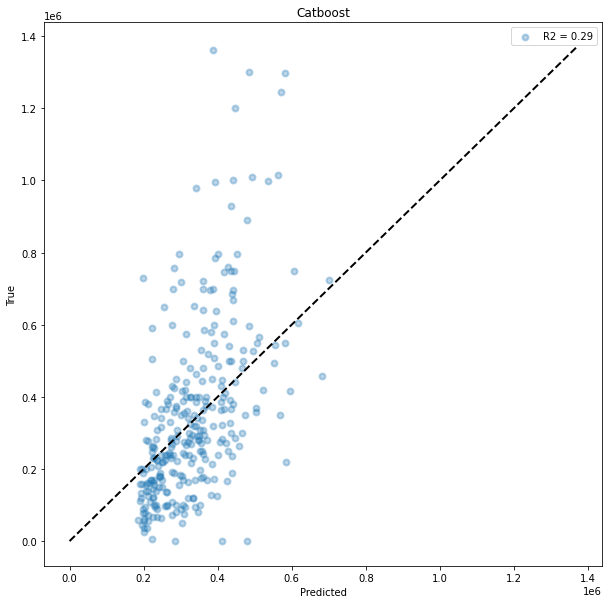

In [ ]:
true = df_test["price"].values
fig, ax = plt.subplots(figsize=(10,10))
score = metrics.r2_score(true, preds)
plt.scatter(preds, true, lw=2, alpha=0.3, 
            label='R2 = %0.2f' % (score))

plt.plot([min(train_label),max(train_label)], [min(train_label),max(train_label)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Catboost')
plt.legend()
plt.show()